In [1]:
import operator
from pprint import pprint
import itertools
import re
import numpy as np

from SolrClient import SolrClient

import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import matutils

import pyLDAvis.gensim

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline

D:\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
pyLDAvis.enable_notebook()

In [3]:
solr = SolrClient('http://192.168.200.112:8983')

In [4]:
query_def = {
            'q': '-ctr_id:id_document_spell',
            'indent': 'true',
            'fl': 'ctr_id,ctr_content_nlp',
            'wt': 'json',
            'rows': '2147483647'
            }

In [5]:
res = solr.query('default',query_def)

2017-07-27 22:33:40,648 : DEBUG : Sending Request to http://192.168.200.112:8983/default/select with q=-ctr_id:id_document_spell, indent=false, fl=ctr_id,ctr_content_nlp, wt=json, rows=2147483647
2017-07-27 22:33:40,653 : DEBUG : Starting new HTTP connection (1): 192.168.200.112
2017-07-27 22:33:40,722 : DEBUG : http://192.168.200.112:8983 "POST /default/select?q=-ctr_id%3Aid_document_spell&indent=false&fl=ctr_id%2Cctr_content_nlp&wt=json&rows=2147483647 HTTP/1.1" 200 None
2017-07-27 22:33:50,549 : DEBUG : Request Completed in 9.9 Seconds


In [6]:
res.get_results_count()

41283

In [7]:
def process_texts(docs, text_fields, language='portuguese'):
    """
    Function to process texts. Following are the steps we take:

    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).

    Parameters:
    ----------
    texts: Tokenized texts.

    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = []
    for doc in docs:
        text = None
        for text_field in text_fields:
            if text_field in doc:
                text = gensim.utils.simple_preprocess(doc[text_field], deacc=False, min_len=3)
                texts.append(text)
    stops = set(stopwords.words(language))
    texts = [[word for word in text if word not in stops] for text in texts]
    
    phrases = gensim.models.Phrases(texts)
    bigram = gensim.models.phrases.Phraser(phrases)
    
    for idx in range(len(texts)):
        for token in bigram[texts[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                texts[idx].append(token)
    
    return texts

In [8]:
%%time
train_texts = process_texts(res.docs, ['ctr_content_nlp'])

2017-07-27 22:34:29,895 : INFO : collecting all words and their counts
2017-07-27 22:34:29,895 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2017-07-27 22:34:30,843 : INFO : PROGRESS: at sentence #10000, processed 628115 words and 300186 word types
2017-07-27 22:34:31,864 : INFO : PROGRESS: at sentence #20000, processed 1306750 words and 507904 word types
2017-07-27 22:34:32,817 : INFO : PROGRESS: at sentence #30000, processed 1887305 words and 724793 word types
2017-07-27 22:34:33,602 : INFO : PROGRESS: at sentence #40000, processed 2402761 words and 895731 word types
2017-07-27 22:34:33,712 : INFO : collected 913778 word types from a corpus of 2463567 words (unigram + bigrams) and 41283 sentences
2017-07-27 22:34:33,714 : INFO : using 913778 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2017-07-27 22:34:33,716 : INFO : source_vocab length 913778
2017-07-27 22:34:43,138 : INFO : Phraser built with 11441 11441 phrasegr

Wall time: 24.7 s


In [9]:
len(train_texts)

41283

In [10]:
str(train_texts[0])

"['junho', 'tecnologia', 'tecnologia', 'informação', 'comunicação', 'experiência', 'publicar', 'informação', 'tecnologia', 'serviço', 'setor', 'excelência', 'inovação', 'ged', 'ecm', 'bpm', 'desenvolvimento', 'portal', 'empresarial', 'junho', 'tecnologia', 'tecnologia', 'informação', 'comunicação', 'experiência', 'publicar', 'informação', 'tecnologia', 'serviço', 'setor', 'excelência', 'inovação', 'cação', 'digital', 'cial', 'governo', 'ged', 'ecm', 'enterprise', 'bpm', 'portal', 'tecnologia_informação', 'informação_tecnologia', 'setor_excelência', 'inovação_ged', 'ecm_bpm', 'desenvolvimento_portal', 'tecnologia_informação', 'informação_tecnologia', 'setor_excelência', 'inovação_cação', 'digital_cial', 'governo_ged', 'ecm_enterprise']"

In [11]:
dictionary = Dictionary(train_texts)

2017-07-27 22:35:20,204 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-07-27 22:35:21,117 : INFO : adding document #10000 to Dictionary(30891 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:22,082 : INFO : adding document #20000 to Dictionary(44578 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:22,950 : INFO : adding document #30000 to Dictionary(56862 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:23,720 : INFO : adding document #40000 to Dictionary(66053 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:23,828 : INFO : built Dictionary(66863 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...) from 41283 documents (total 2826183 corpus positions)


In [12]:
print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 66863


In [13]:
dictionary.save('mp_dictionary_full.dict')

2017-07-27 22:35:33,887 : INFO : saving Dictionary object under mp_dictionary_full.dict, separately None
2017-07-27 22:35:33,920 : INFO : saved mp_dictionary_full.dict


In [14]:
dictionary_filtered = Dictionary(train_texts)
dictionary_filtered.save('mp_dictionary_filtered.dict')
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)
dictionary_filtered.filter_extremes(no_above=0.5)
print('Number of unique tokens: %d' % len(dictionary_filtered))

2017-07-27 22:35:39,166 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-07-27 22:35:40,085 : INFO : adding document #10000 to Dictionary(30891 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:41,048 : INFO : adding document #20000 to Dictionary(44578 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:41,914 : INFO : adding document #30000 to Dictionary(56862 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:42,680 : INFO : adding document #40000 to Dictionary(66053 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:42,777 : INFO : built Dictionary(66863 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...) from 41283 documents (total 2826183 corpus positions)
2017-07-27 22:35:42,778 : INFO : saving Dictionary object under 

Number of unique tokens: 22751


In [15]:
corpus = [dictionary.doc2bow(text) for text in train_texts]
print('Number of documents on full: %d' % len(corpus))
corpus_filtered = [dictionary_filtered.doc2bow(text) for text in train_texts]
print('Number of documents on filtered: %d' % len(corpus_filtered))

Number of documents on full: 41283
Number of documents on filtered: 41283


In [17]:
%%time
ldamodel_filtered = LdaModel(corpus=corpus_filtered, num_topics=10, id2word=dictionary_filtered, chunksize=45000, passes=20, iterations=400, eval_every=1, alpha='auto', eta='auto')

2017-07-27 22:43:34,607 : INFO : using autotuned alpha, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
2017-07-27 22:43:34,613 : INFO : using serial LDA version on this node
2017-07-27 22:43:35,850 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-07-27 22:43:37,712 : DEBUG : bound: at document #0
2017-07-27 22:50:45,906 : INFO : -10.707 per-word bound, 1672.0 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-27 22:50:45,906 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-07-27 22:50:45,906 : DEBUG : performing inference on a chunk of 41283 documen

2017-07-27 23:10:46,745 : INFO : topic diff=0.424524, rho=0.447214
2017-07-27 23:10:47,284 : DEBUG : bound: at document #0
2017-07-27 23:13:38,204 : INFO : -7.297 per-word bound, 157.3 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-27 23:13:38,204 : INFO : PROGRESS: pass 4, at document #41283/41283
2017-07-27 23:13:38,204 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-27 23:14:40,532 : DEBUG : 41275/41283 documents converged within 400 iterations
2017-07-27 23:14:41,305 : INFO : optimized alpha [0.045251002781226367, 0.043903028190714552, 0.053412269169971216, 0.044309195235710745, 0.044890271285409893, 0.055866782337922805, 0.059427230585255925, 0.051763749277996006, 0.064600815450115354, 0.043803306012486769]
2017-07-27 23:14:41,305 : DEBUG : updating topics
2017-07-27 23:14:41,630 : INFO : topic #9 (0.044): 0.028*"válido" + 0.014*"campo" + 0.012*"sábado" + 0.008*"ano" + 0.008*"abril" + 0.008*"maio" + 0.008*"justiça"

2017-07-27 23:29:05,279 : INFO : optimized alpha [0.038552638419173682, 0.037490901197711854, 0.051357979275438476, 0.038693248018335388, 0.040887692577205356, 0.050178476484768191, 0.0547405804819402, 0.04541675616368647, 0.063819936195200919, 0.039392654699114911]
2017-07-27 23:29:05,279 : DEBUG : updating topics
2017-07-27 23:29:05,522 : INFO : topic #1 (0.037): 0.016*"lei" + 0.016*"decreto" + 0.013*"pub" + 0.012*"abril" + 0.012*"portaria" + 0.011*"maio" + 0.011*"publicar" + 0.010*"janeiro" + 0.009*"brasil" + 0.009*"sergipe"
2017-07-27 23:29:05,522 : INFO : topic #0 (0.039): 0.029*"licença" + 0.027*"efp" + 0.023*"cetesb" + 0.021*"sito" + 0.019*"lei" + 0.017*"público" + 0.014*"pedido" + 0.014*"saúde" + 0.012*"tratar" + 0.011*"operação"
2017-07-27 23:29:05,537 : INFO : topic #2 (0.051): 0.023*"valor" + 0.016*"dezembro" + 0.014*"exercício" + 0.014*"ativo" + 0.013*"companhia" + 0.012*"demonstração" + 0.010*"caixa" + 0.009*"resultado" + 0.009*"ação" + 0.008*"passivo"
2017-07-27 23:29:05,

2017-07-27 23:42:40,636 : INFO : topic #0 (0.035): 0.030*"licença" + 0.028*"efp" + 0.025*"cetesb" + 0.022*"sito" + 0.019*"lei" + 0.018*"público" + 0.014*"pedido" + 0.014*"saúde" + 0.013*"tratar" + 0.012*"operação"
2017-07-27 23:42:40,636 : INFO : topic #2 (0.050): 0.023*"valor" + 0.016*"dezembro" + 0.015*"exercício" + 0.014*"companhia" + 0.013*"ativo" + 0.013*"demonstração" + 0.010*"caixa" + 0.009*"ação" + 0.009*"resultado" + 0.008*"passivo"
2017-07-27 23:42:40,646 : INFO : topic #6 (0.053): 0.037*"item" + 0.025*"preço" + 0.022*"valor" + 0.014*"empresa" + 0.014*"merc" + 0.012*"edital" + 0.012*"proposta" + 0.010*"processo" + 0.009*"aquisição" + 0.009*"unidade"
2017-07-27 23:42:40,647 : INFO : topic #8 (0.063): 0.015*"objeto" + 0.014*"processo" + 0.013*"prazo" + 0.012*"valor" + 0.012*"hora" + 0.011*"empresa" + 0.010*"contrato" + 0.010*"termo" + 0.008*"lei" + 0.008*"edital"
2017-07-27 23:42:40,650 : INFO : topic diff=0.333971, rho=0.267261
2017-07-27 23:42:41,044 : DEBUG : bound: at docum

2017-07-27 23:55:56,927 : INFO : topic #6 (0.052): 0.038*"item" + 0.025*"preço" + 0.021*"valor" + 0.015*"empresa" + 0.014*"merc" + 0.012*"edital" + 0.012*"proposta" + 0.010*"processo" + 0.009*"aquisição" + 0.009*"unidade"
2017-07-27 23:55:56,928 : INFO : topic #8 (0.063): 0.015*"objeto" + 0.014*"processo" + 0.013*"prazo" + 0.013*"valor" + 0.012*"hora" + 0.011*"empresa" + 0.011*"contrato" + 0.010*"termo" + 0.008*"lei" + 0.008*"assinatura"
2017-07-27 23:55:56,932 : INFO : topic diff=0.310421, rho=0.235702
2017-07-27 23:55:57,297 : DEBUG : bound: at document #0
2017-07-27 23:58:29,027 : INFO : -7.141 per-word bound, 141.1 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-27 23:58:29,027 : INFO : PROGRESS: pass 17, at document #41283/41283
2017-07-27 23:58:29,027 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-27 23:59:13,705 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-27 23:59:14,476 : INFO : optim

Wall time: 1h 22min 14s


In [18]:
pyLDAvis.gensim.prepare(ldamodel_filtered, corpus_filtered, dictionary_filtered)

2017-07-28 06:09:40,189 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 06:10:22,049 : DEBUG : 41283/41283 documents converged within 400 iterations
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      19.055493        1       1 -0.175819  0.013270
8      17.081760        1       2 -0.061174  0.084170
6      12.271089        1       3 -0.089572  0.177646
4      11.475648        1       4 -0.053959  0.105974
5      10.923700        1       5  0.125320 -0.024217
3      10.248249        1       6 -0.112016 -0.203810
7       7.224972        1       7 -0.049672  0.043886
0       4.971096        1       8  0.231631 -0.103898
9       3.607538        1       9  0.234001  0.109746
1       3.140455        1      10 -0.048740 -0.202768, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
5660   Default  11425.000000      candidato  11425.000000  30.0000  30.0000
186    Default  24546.000000            lei  24546.000000  29.0000  29.0000
310    Default  17440.000000           item  17440.000000  28.0000  28.0000
1916   Default  14599.000000        decreto  14599.000000  27.0000  27.0000
592    Default   9836.000000          preço   9836.000000  26.0000  26.0000
848    Default   5177.000000        licença   5177.000000  25.0000  25.0000
5619   Default   7530.000000      inscrição   7530.000000  24.0000  24.0000
19642  Default   5733.000000         estado   5733.000000  23.0000  23.0000
8589   Default   3987.000000         válido   3987.000000  22.0000  22.0000
35     Default  14904.000000       dezembro  14904.000000  21.0000  21.0000
116    Default  15701.000000        período  15701.000000  20.0000  20.0000
18689  Default   3932.000000            efp   3932.000000  19.0000  19.0000
5658   Default   5493.000000        sergipe   5493.000000  18.0000  18.0000
113    Default   7154.000000          ativo   7154.000000  17.0000  17.0000
182    Default  20587.000000          termo  20587.000000  16.0000  16.0000
852    Default   4407.000000           sito   4407.000000  15.0000  15.0000
846    Default   3430.000000         cetesb   3430.000000  14.0000  14.0000
85     Default   8488.000000      companhia   8488.000000  13.0000  13.0000
51     Default   6709.000000   demonstração   6709.000000  12.0000  12.0000
570    Default  11435.000000         edital  11435.000000  11.0000  11.0000
4606   Default   4500.000000           merc   4500.000000  10.0000  10.0000
609    Default  10622.000000         objeto  10622.000000   9.0000   9.0000
153    Default  13319.000000        empresa  13319.000000   8.0000   8.0000
67     Default  28679.000000          valor  28679.000000   7.0000   7.0000
2435   Default   6340.000000       portaria   6340.000000   6.0000   6.0000
5      Default  10398.000000       publicar  10398.000000   5.0000   5.0000
10162  Default   3701.000000            peb   3701.000000   4.0000   4.0000
141    Default   5953.000000       operação   5953.000000   3.0000   3.0000
844    Default   3979.000000        público   3979.000000   2.0000   2.0000
6202   Default   4027.000000       concurso   4027.000000   1.0000   1.0000
...        ...           ...            ...           ...      ...      ...
1074   Topic10    544.830223          texto    945.880348   2.9092  -5.0536
4666   Topic10    260.818621    integrantes    352.489416   3.1596  -5.7902
12173  Topic10    254.802221  meio_portaria    346.481404   3.1535  -5.8136
16273  Topic10    500.453323         membro   1199.915904   2.5863  -5.1386
2435   Topic10   1324.042748       portaria   6340.211353   1.8946  -4.1656
190    Topic10    499.974167         edição   1364.420611   2.4569  -5.1395
192    Topic10    579.058394         página   1903.978453   2.2705  -4.9927
130    Topic10    404.629999         imóvel   1065.189064   2.4929  -5.3511
1916   Topic10   1429.704192        decreto  14599.526514   1.1373  -4.0889
1053   Topic10    523.467786        arquivo   1959.939507   2.1406  -5.0936
394    Topic10    334.449259         fran

In [19]:
%%time
coherence_model = CoherenceModel(model=ldamodel_filtered, texts=train_texts, dictionary=dictionary_filtered, coherence='c_v')
print(coherence_model.get_coherence())

2017-07-28 06:11:34,333 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-07-28 06:11:38,949 : INFO : 237 batches submitted to accumulate stats from 15168 documents (-570270 virtual)
2017-07-28 06:11:39,174 : INFO : 259 batches submitted to accumulate stats from 16576 documents (-623821 virtual)
2017-07-28 06:11:39,420 : INFO : 277 batches submitted to accumulate stats from 17728 documents (-641571 virtual)
2017-07-28 06:11:39,495 : INFO : 282 batches submitted to accumulate stats from 18048 documents (-643092 virtual)
2017-07-28 06:11:39,546 : INFO : 285 batches submitted to accumulate stats from 18240 documents (-643898 virtual)
2017-07-28 06:11:39,671 : INFO : 291 batches submitted to accumulate stats from 18624 documents (-644882 virtual)
2017-07-28 06:11:39,719 : INFO : 294 batches submitted to accumulate stats from 18816 documents (-644910 virtual)
2017-07-28 06:11:39,812 : INFO : 299 batches submitted

0.626145841764
Wall time: 9.02 s


In [20]:
np.arange(10, 101, 10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [21]:
def get_best_model_by_topics(dictionary, corpus, texts, limit, chunksize=20000, passes=20, iterations=200):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    # Set training parameters.
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.
    
    lm_list = {}
    co_va = {}
    for num_topics in np.arange(10, limit, 10):
        lm = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, \
                      num_topics=num_topics, chunksize=chunksize, iterations=iterations, \
                      eval_every=eval_every, alpha='auto', eta='auto')
        lm_list[num_topics - 1] = lm
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        co_va[num_topics - 1] = cm.get_coherence()
    top_models = sorted(co_va.items(), key=operator.itemgetter(1), reverse=True)
    print('Melhores 5 modelos', top_models[:5])
    return lm_list[top_models[0][0]], lm_list, co_va

In [ ]:
%%time
best_model_filtered, lm_filtered, c_v_filtered = get_best_model_by_topics(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=101, passes=15, iterations=400, chunksize=45000)
print(best_model_filtered.show_topics(formatted=True))

2017-07-28 06:14:07,980 : INFO : using autotuned alpha, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
2017-07-28 06:14:07,985 : INFO : using serial LDA version on this node
2017-07-28 06:14:09,270 : INFO : running online (multi-pass) LDA training, 10 topics, 15 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-07-28 06:14:11,168 : DEBUG : bound: at document #0
2017-07-28 06:21:35,593 : INFO : -10.709 per-word bound, 1674.1 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 06:21:35,593 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-07-28 06:21:35,593 : DEBUG : performing inference on a chunk of 41283 documen

2017-07-28 06:42:18,416 : INFO : topic diff=0.430462, rho=0.447214
2017-07-28 06:42:18,960 : DEBUG : bound: at document #0
2017-07-28 06:45:11,609 : INFO : -7.306 per-word bound, 158.2 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 06:45:11,609 : INFO : PROGRESS: pass 4, at document #41283/41283
2017-07-28 06:45:11,609 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 06:46:16,210 : DEBUG : 41277/41283 documents converged within 400 iterations
2017-07-28 06:46:17,015 : INFO : optimized alpha [0.044170519673194575, 0.050218548762373957, 0.056243150354388399, 0.050142489758895022, 0.044506869117539802, 0.04701069886934324, 0.056462396947097468, 0.058859669480387074, 0.044392635989208659, 0.058358193042489709]
2017-07-28 06:46:17,015 : DEBUG : updating topics
2017-07-28 06:46:17,371 : INFO : topic #0 (0.044): 0.021*"icms" + 0.018*"decreto" + 0.015*"lei" + 0.015*"dezembro" + 0.011*"termo" + 0.009*"ponto" + 0.009*"item" 

2017-07-28 07:01:00,730 : DEBUG : 41281/41283 documents converged within 400 iterations
2017-07-28 07:01:01,537 : INFO : optimized alpha [0.03687773133250432, 0.042467731329579664, 0.054636497433898423, 0.045964050330561598, 0.038588257356147702, 0.042792263473459408, 0.052420992130068463, 0.055314758780527586, 0.039037380962845987, 0.054927589615571176]
2017-07-28 07:01:01,537 : DEBUG : updating topics
2017-07-28 07:01:01,800 : INFO : topic #0 (0.037): 0.024*"icms" + 0.021*"decreto" + 0.017*"lei" + 0.017*"dezembro" + 0.012*"termo" + 0.010*"ponto" + 0.009*"contribuinte" + 0.009*"regulamento" + 0.008*"publicar" + 0.008*"item"
2017-07-28 07:01:01,800 : INFO : topic #4 (0.039): 0.023*"válido" + 0.022*"efp" + 0.018*"protocolo" + 0.018*"assunto" + 0.017*"brasil" + 0.016*"apenso" + 0.015*"licença" + 0.013*"saúde" + 0.013*"pedido" + 0.013*"tratar"
2017-07-28 07:01:01,816 : INFO : topic #2 (0.055): 0.018*"objeto" + 0.015*"valor" + 0.014*"contrato" + 0.012*"prazo" + 0.012*"empresa" + 0.011*"pro

2017-07-28 07:15:07,753 : INFO : topic #0 (0.033): 0.025*"icms" + 0.022*"decreto" + 0.018*"dezembro" + 0.017*"lei" + 0.013*"termo" + 0.010*"ponto" + 0.010*"contribuinte" + 0.010*"regulamento" + 0.009*"publicar" + 0.008*"reincidente"
2017-07-28 07:15:07,753 : INFO : topic #4 (0.035): 0.027*"efp" + 0.026*"válido" + 0.022*"assunto" + 0.020*"protocolo" + 0.020*"apenso" + 0.015*"licença" + 0.015*"brasil" + 0.014*"saúde" + 0.014*"pedido" + 0.013*"tratar"
2017-07-28 07:15:07,753 : INFO : topic #9 (0.052): 0.025*"decreto" + 0.024*"lei" + 0.017*"termo" + 0.016*"período" + 0.013*"estado" + 0.011*"sergipe" + 0.010*"peb" + 0.010*"portaria" + 0.009*"abril" + 0.009*"disposição"
2017-07-28 07:15:07,764 : INFO : topic #7 (0.053): 0.040*"item" + 0.023*"preço" + 0.019*"valor" + 0.016*"empresa" + 0.013*"edital" + 0.013*"processo" + 0.012*"proposta" + 0.009*"aquisição" + 0.008*"pregão" + 0.008*"unidade"
2017-07-28 07:15:07,768 : INFO : topic #2 (0.054): 0.019*"objeto" + 0.015*"valor" + 0.014*"contrato" + 

2017-07-28 07:34:55,527 : INFO : topic #6 (0.040): 0.012*"valor" + 0.012*"item" + 0.012*"assunto" + 0.011*"decreto" + 0.010*"apenso" + 0.008*"brasil" + 0.008*"fevereiro" + 0.008*"icms" + 0.008*"março" + 0.007*"descrição"
2017-07-28 07:34:55,527 : INFO : topic #18 (0.043): 0.018*"termo" + 0.012*"lei" + 0.008*"período" + 0.008*"licença" + 0.008*"efp" + 0.008*"pedido" + 0.007*"processo" + 0.007*"protocolo" + 0.007*"saúde" + 0.007*"tratar"
2017-07-28 07:34:55,540 : INFO : topic #4 (0.044): 0.021*"valor" + 0.009*"lei" + 0.008*"ativo" + 0.008*"companhia" + 0.008*"ano" + 0.007*"total" + 0.006*"termo" + 0.006*"guarulhos" + 0.006*"santos" + 0.006*"dezembro"
2017-07-28 07:34:55,542 : INFO : topic #2 (0.045): 0.019*"valor" + 0.015*"lei" + 0.010*"decreto" + 0.009*"abril" + 0.008*"empresa" + 0.007*"dezembro" + 0.007*"termo" + 0.007*"exercício" + 0.006*"item" + 0.006*"brasil"
2017-07-28 07:34:55,547 : INFO : topic diff=11.273439, rho=1.000000
2017-07-28 07:34:57,008 : DEBUG : bound: at document #0
2

2017-07-28 07:54:25,540 : DEBUG : updating topics
2017-07-28 07:54:26,089 : INFO : topic #14 (0.032): 0.038*"pub" + 0.022*"vig" + 0.010*"pub_vig" + 0.009*"pub_pub" + 0.008*"unid" + 0.007*"ação" + 0.007*"valor" + 0.006*"companhia" + 0.006*"oferta" + 0.006*"item"
2017-07-28 07:54:26,089 : INFO : topic #15 (0.032): 0.020*"demonstração" + 0.018*"decisão" + 0.014*"auditoria" + 0.014*"osasco" + 0.011*"aiim" + 0.011*"processo" + 0.010*"opinião" + 0.010*"recurso" + 0.009*"lei" + 0.009*"decreto"
2017-07-28 07:54:26,089 : INFO : topic #18 (0.039): 0.028*"termo" + 0.014*"lei" + 0.013*"pedido" + 0.012*"licença" + 0.011*"saúde" + 0.010*"período" + 0.009*"tratar" + 0.009*"função" + 0.009*"efp" + 0.009*"despacho"
2017-07-28 07:54:26,102 : INFO : topic #4 (0.041): 0.030*"valor" + 0.017*"ativo" + 0.015*"companhia" + 0.014*"dezembro" + 0.010*"exercício" + 0.009*"ação" + 0.009*"demonstração" + 0.009*"total" + 0.008*"passivo" + 0.008*"resultado"
2017-07-28 07:54:26,106 : INFO : topic #0 (0.043): 0.028*"it

2017-07-28 08:10:00,886 : INFO : optimized alpha [0.044182939916559978, 0.035768103744432865, 0.032456514895867837, 0.03027621331876015, 0.041334867765992114, 0.031899557140204843, 0.0307797564269152, 0.036723791019091789, 0.029520768894898193, 0.031179339180524106, 0.030815081063032875, 0.032784663387823577, 0.037154033790524427, 0.035131964221249812, 0.028678015000163801, 0.028762715587559974, 0.032923862925116301, 0.034579263495990546, 0.03669510411850356, 0.029370676936564321]
2017-07-28 08:10:00,886 : DEBUG : updating topics
2017-07-28 08:10:01,286 : INFO : topic #14 (0.029): 0.049*"pub" + 0.027*"vig" + 0.013*"pub_pub" + 0.012*"pub_vig" + 0.010*"unid" + 0.009*"oferta" + 0.008*"ação" + 0.007*"total" + 0.006*"instrução" + 0.006*"cvm"
2017-07-28 08:10:01,286 : INFO : topic #15 (0.029): 0.024*"decisão" + 0.021*"demonstração" + 0.017*"osasco" + 0.016*"auditoria" + 0.014*"aiim" + 0.014*"processo" + 0.013*"recurso" + 0.011*"opinião" + 0.011*"partir" + 0.010*"lei"
2017-07-28 08:10:01,286 

2017-07-28 08:21:14,875 : DEBUG : bound: at document #0
2017-07-28 08:23:59,037 : INFO : -7.024 per-word bound, 130.1 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 08:23:59,037 : INFO : PROGRESS: pass 12, at document #41283/41283
2017-07-28 08:23:59,037 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 08:24:54,534 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 08:24:55,397 : INFO : optimized alpha [0.045495926494562376, 0.035681387857249315, 0.030655079894824487, 0.027915677190125637, 0.041915205221069, 0.030110067316207887, 0.029378272754535743, 0.036731406584917838, 0.027850394565208519, 0.029889810710057772, 0.029728630749251937, 0.03251675992449931, 0.037283608789614023, 0.033566301790788622, 0.026943233526219749, 0.026736816218280394, 0.031812746732673182, 0.035897545381553507, 0.035081166229808357, 0.027286966822035134]
2017-07-28 08:24:55,413 : DEBUG : updating topics
2017-07-28 

2017-07-28 08:32:29,889 : INFO : using serial LDA version on this node
2017-07-28 08:32:33,635 : INFO : running online (multi-pass) LDA training, 30 topics, 15 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-07-28 08:32:38,185 : DEBUG : bound: at document #0
2017-07-28 08:40:03,275 : INFO : -11.162 per-word bound, 2291.5 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 08:40:03,275 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-07-28 08:40:03,275 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 08:45:37,181 : DEBUG : 38212/41283 documents converged within 400 iterations
2017-07-28 08:45:38,022 : INFO : optimized alpha [0.0298924311400868, 0.029179235408911531, 0.029149348796884002, 0.028864864403009619, 0.029843642122671012, 0.030029438921024477, 0.03015285

2017-07-28 09:00:57,902 : DEBUG : updating topics
2017-07-28 09:00:58,699 : INFO : topic #20 (0.025): 0.024*"total" + 0.022*"trim" + 0.010*"linha" + 0.009*"itapevi" + 0.009*"lote" + 0.009*"cor" + 0.009*"placa" + 0.009*"motor" + 0.008*"rodovia" + 0.008*"ano"
2017-07-28 09:00:58,699 : INFO : topic #12 (0.025): 0.052*"campina" + 0.033*"campinas" + 0.019*"campina_campina" + 0.018*"mogi" + 0.018*"bauru" + 0.017*"cruz" + 0.013*"janeiro" + 0.012*"daee" + 0.011*"horário" + 0.011*"prazo"
2017-07-28 09:00:58,712 : INFO : topic #26 (0.029): 0.015*"osasco" + 0.012*"edital" + 0.010*"junho" + 0.009*"prazo" + 0.008*"item" + 0.008*"hora" + 0.008*"documento" + 0.008*"maio" + 0.008*"inscrição" + 0.007*"valor"
2017-07-28 09:00:58,715 : INFO : topic #4 (0.032): 0.025*"valor" + 0.018*"companhia" + 0.015*"dezembro" + 0.015*"ativo" + 0.012*"exercício" + 0.010*"ação" + 0.009*"passivo" + 0.008*"real" + 0.008*"abril" + 0.008*"demonstração"
2017-07-28 09:00:58,717 : INFO : topic #0 (0.033): 0.027*"item" + 0.026*

2017-07-28 09:13:00,832 : INFO : topic diff=0.534401, rho=0.353553
2017-07-28 09:13:01,587 : DEBUG : bound: at document #0
2017-07-28 09:15:52,743 : INFO : -6.996 per-word bound, 127.7 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 09:15:52,759 : INFO : PROGRESS: pass 7, at document #41283/41283
2017-07-28 09:15:52,759 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 09:16:53,802 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 09:16:54,715 : INFO : optimized alpha [0.037574423437139494, 0.023765445128069423, 0.028851566619227151, 0.024722726340880623, 0.035216846230213879, 0.025814175473151017, 0.024737965349735554, 0.028818945520350303, 0.026455027589057333, 0.024134945635033826, 0.025216048772553512, 0.023876443702367956, 0.023682324709924554, 0.023833440584335494, 0.028569298327632935, 0.024134241748777509, 0.02606078441743755, 0.02467172755320942, 0.025551307008243002, 0.0233980085086

2017-07-28 09:28:24,364 : DEBUG : updating topics
2017-07-28 09:28:24,843 : INFO : topic #20 (0.022): 0.060*"total" + 0.022*"trim" + 0.020*"placa" + 0.019*"ano" + 0.018*"motor" + 0.016*"cor" + 0.014*"lote" + 0.014*"honda" + 0.013*"centro" + 0.012*"total_total"
2017-07-28 09:28:24,843 : INFO : topic #13 (0.022): 0.132*"merc" + 0.063*"ponto" + 0.055*"merc_merc" + 0.025*"faixa" + 0.022*"linha" + 0.018*"distância" + 0.017*"limite" + 0.017*"domínio" + 0.017*"projeto" + 0.016*"azimute"
2017-07-28 09:28:24,847 : INFO : topic #2 (0.030): 0.041*"candidato" + 0.025*"inscrição" + 0.017*"prova" + 0.015*"concurso" + 0.013*"documento" + 0.013*"edital" + 0.010*"prazo" + 0.008*"hora" + 0.007*"curso" + 0.007*"nota"
2017-07-28 09:28:24,849 : INFO : topic #4 (0.037): 0.027*"valor" + 0.018*"companhia" + 0.017*"dezembro" + 0.016*"ativo" + 0.013*"exercício" + 0.010*"ação" + 0.009*"passivo" + 0.009*"demonstração" + 0.008*"real" + 0.008*"milhares"
2017-07-28 09:28:24,851 : INFO : topic #0 (0.040): 0.026*"valo

2017-07-28 09:39:48,745 : INFO : topic diff=0.367861, rho=0.258199
2017-07-28 09:39:49,299 : DEBUG : bound: at document #0
2017-07-28 09:42:36,439 : INFO : -6.925 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 09:42:36,439 : INFO : PROGRESS: pass 14, at document #41283/41283
2017-07-28 09:42:36,439 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 09:43:35,267 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 09:43:36,240 : INFO : optimized alpha [0.043046492434521098, 0.022007263305074951, 0.030475418252555658, 0.024564641336988102, 0.039042547306305173, 0.024622351556251174, 0.023109695348740571, 0.029165124316025522, 0.025365504520146531, 0.022944457323298591, 0.024387044846307541, 0.021857174565593579, 0.021979839470346142, 0.021191963039447387, 0.03058795011269767, 0.022300970826941185, 0.026448043964342496, 0.022946775174775905, 0.025154328224654895, 0.02168445648

2017-07-28 10:03:48,998 : DEBUG : updating topics
2017-07-28 10:03:50,381 : INFO : topic #15 (0.021): 0.013*"preço" + 0.009*"ponto" + 0.009*"empresarial" + 0.008*"sac" + 0.008*"cidade" + 0.008*"cliente" + 0.008*"fase" + 0.007*"justiça" + 0.007*"ordem" + 0.007*"atender"
2017-07-28 10:03:50,381 : INFO : topic #14 (0.021): 0.013*"piracicaba" + 0.010*"vol" + 0.009*"valor" + 0.009*"brasil" + 0.008*"março" + 0.007*"mil" + 0.007*"empresa" + 0.007*"real" + 0.006*"exercício" + 0.006*"epp"
2017-07-28 10:03:50,381 : INFO : topic #31 (0.023): 0.034*"candidato" + 0.024*"inscrição" + 0.016*"prova" + 0.012*"concurso" + 0.011*"prazo" + 0.011*"documento" + 0.010*"edital" + 0.007*"nota" + 0.006*"título" + 0.006*"item"
2017-07-28 10:03:50,398 : INFO : topic #30 (0.023): 0.024*"valor" + 0.017*"exercício" + 0.014*"ativo" + 0.014*"companhia" + 0.013*"dezembro" + 0.012*"demonstração" + 0.009*"ação" + 0.008*"resultado" + 0.008*"lei" + 0.008*"caixa"
2017-07-28 10:03:50,400 : INFO : topic #33 (0.023): 0.032*"me

2017-07-28 10:18:12,511 : INFO : topic #31 (0.024): 0.037*"candidato" + 0.025*"inscrição" + 0.017*"prova" + 0.014*"concurso" + 0.012*"documento" + 0.011*"edital" + 0.011*"prazo" + 0.007*"nota" + 0.007*"item" + 0.007*"caso"
2017-07-28 10:18:12,528 : INFO : topic #35 (0.024): 0.050*"item" + 0.040*"valor" + 0.021*"real" + 0.021*"empresa" + 0.018*"processo" + 0.018*"mil" + 0.016*"objeto" + 0.013*"preço" + 0.013*"centavo" + 0.013*"aquisição"
2017-07-28 10:18:12,531 : INFO : topic #30 (0.024): 0.028*"valor" + 0.019*"exercício" + 0.018*"ativo" + 0.018*"companhia" + 0.016*"dezembro" + 0.014*"demonstração" + 0.011*"ação" + 0.011*"caixa" + 0.010*"resultado" + 0.010*"lucro"
2017-07-28 10:18:12,537 : INFO : topic diff=1.109673, rho=0.408248
2017-07-28 10:18:13,451 : DEBUG : bound: at document #0


In [51]:
print(len(c_v_filtered))
print(c_v_filtered.values())

10
dict_values([0.68482615384866286, 0.6558313733417841, 0.58298420280279983, 0.59931109951526929, 0.60019090905618333, 0.55700435271890514, 0.58063166375119313, 0.57961327764070791, 0.58471380722208388, 0.54824290760117034])


In [49]:
def evaluate_graph(coherence_values):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    
        
    # Show graph
    x = range(1, len(c_v_filtered) + 1)
    plt.plot(x, list(coherence_values.values()))
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

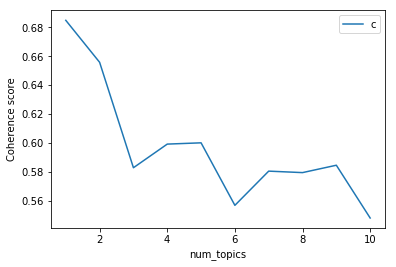

In [50]:
evaluate_graph(c_v_filtered)

In [52]:
# Build topic listings from each model.
def top_topics(lda, num_words=20):
    str_topics = []
    for topic in lda.state.get_lambda():
        topic = topic / topic.sum()  # normalize to probability distribution
        bestn = matutils.argsort(topic, topn=num_words, reverse=True)
        beststr = [lda.id2word[_id] for _id in bestn]
        str_topics.append(beststr)
    return str_topics

def get_super_topic(trained_models):
    model_topics = {}
    super_topic = set()
    for num_topics, model in trained_models.items():
        topics_as_topn_terms = top_topics(model)
        model_topics[num_topics] = topics_as_topn_terms
        super_topic.update(itertools.chain.from_iterable(topics_as_topn_terms))
    print("Number of relevant terms: %d" % len(super_topic))
    return super_topic, model_topics

In [53]:
super_topic, model_topics = get_super_topic(lm_filtered)
print(super_topic)

Number of relevant terms: 1180
{'festividade', 'inovação', 'sala_sessão', 'tecnologia', 'fes', 'exposição', 'membro', 'renascer', 'cehop', 'manifestação', 'hgjaf', 'beneficiário', 'comunicação_icms', 'personalidade', 'premiação', 'finalidade', 'saúde', 'gratificar_presença', 'revogado_revogado', 'ribeirópolis', 'mil', 'categoria', 'recurso', 'ciência', 'emprego', 'gado', 'direta', 'localização', 'falecer', 'carira', 'apurar', 'cessionária', 'número', 'combate_pobreza', 'previdência', 'norte', 'deputado', 'ciência_tecnologia', 'referência', 'autonomia', 'proposta', 'programar_período', 'escrivão', 'infração', 'meio', 'domínio', 'anexos', 'natureza_estrutura', 'inscrição_cadastro', 'ativar', 'assessoria', 'aplicação_faixa', 'autarquia', 'imposto', 'integrante', 'financiar', 'arrecadar', 'aposentadoria', 'seplantec', 'icm_icms', 'sessão', 'despesa_aplicação', 'execução', 'municipal', 'coleta', 'novembro', 'piauí', 'seleção', 'guarda', 'pares', 'fomento', 'substituir', 'engenharia', 'lubri

In [54]:
%%time
# Now estimate the probabilities for the CoherenceModel

cm = CoherenceModel(
    topics=[super_topic], texts=train_texts,
    dictionary=dictionary_filtered, coherence='c_v')
cm.estimate_probabilities()

2017-07-27 19:54:20,967 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-07-27 19:54:25,716 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-8621 virtual)
2017-07-27 19:54:35,598 : INFO : 3 accumulators retrieved from output queue
2017-07-27 19:54:36,100 : INFO : accumulated word occurrence stats for 25479 virtual documents


Wall time: 15.3 s


In [55]:
cm.get_coherence_per_topic()

[0.78689280083048796]

In [56]:
%%time
import numpy as np
# Next we perform the coherence evaluation for each of the models.
# Since we have already precomputed the probabilities, this simply
# involves using the accumulated stats in the `CoherenceModel` to
# perform the evaluations, which should be pretty quick.

coherences = {}
for num_topics, topics in model_topics.items():
    cm.topics = topics

    # We evaluate at various values of N and average them. This is a more robust,
    # according to: http://people.eng.unimelb.edu.au/tbaldwin/pubs/naacl2016.pdf
    coherence_at_n = {}
    for n in (20, 15, 10, 5):
        cm.topn = n
        topic_coherences = cm.get_coherence_per_topic()
        #print('coherence per topic for', n, 'topics', topic_coherences)
        
        # Let's record the coherences for each topic, as well as the aggregated
        # coherence across all of the topics.
        coherence_at_n[n] = (topic_coherences, cm.aggregate_measures(topic_coherences))
        #print('coherence at', n, 'topics', cm.aggregate_measures(topic_coherences))
        
    topic_coherences, avg_coherences = zip(*coherence_at_n.values())
    avg_topic_coherences = np.vstack(topic_coherences).mean(0)
    avg_coherence = np.mean(avg_coherences)
    print("Avg coherence for num_topics=%d: %.5f" % (num_topics, avg_coherence))
    coherences[num_topics] = (avg_topic_coherences, avg_coherence)

Avg coherence for num_topics=9: 0.62309
Avg coherence for num_topics=19: 0.60203
Avg coherence for num_topics=29: 0.52043
Avg coherence for num_topics=39: 0.54581
Avg coherence for num_topics=49: 0.54421
Avg coherence for num_topics=59: 0.51751
Avg coherence for num_topics=69: 0.53740
Avg coherence for num_topics=79: 0.52160
Avg coherence for num_topics=89: 0.52129
Avg coherence for num_topics=99: 0.49987
Wall time: 2min 26s


In [57]:
# Print the coherence rankings
avg_coherence = [(num_topics, avg_coherence) for num_topics, (_, avg_coherence) in coherences.items()]
ranked = sorted(avg_coherence, key=lambda tup: tup[1], reverse=True)
print("Ranked by average '%s' coherence:\n" % cm.coherence)
for item in ranked:
    print("num_topics=%d:\t%.4f" % item)
print("\nBest: %d" % ranked[0][0])

Ranked by average 'c_v' coherence:

num_topics=9:	0.6231
num_topics=19:	0.6020
num_topics=39:	0.5458
num_topics=49:	0.5442
num_topics=69:	0.5374
num_topics=79:	0.5216
num_topics=89:	0.5213
num_topics=29:	0.5204
num_topics=59:	0.5175
num_topics=99:	0.4999

Best: 9


In [58]:
best_model_filtered.print_topics()

2017-07-27 20:00:32,287 : INFO : topic #0 (0.035): 0.045*"área" + 0.028*"terra" + 0.023*"área_terra" + 0.021*"fim" + 0.020*"imóvel" + 0.018*"desapropriação" + 0.014*"implantar" + 0.013*"forma" + 0.012*"metro" + 0.012*"propriedade"
2017-07-27 20:00:32,289 : INFO : topic #1 (0.048): 0.078*"icms" + 0.032*"regulamento" + 0.028*"estado" + 0.023*"operação" + 0.022*"comunicação" + 0.021*"fazenda" + 0.018*"redação" + 0.017*"regulamento_icms" + 0.016*"comunicação_icms" + 0.015*"efeito"
2017-07-27 20:00:32,290 : INFO : topic #2 (0.069): 0.088*"estado" + 0.024*"fevereiro" + 0.022*"abril" + 0.022*"janeiro" + 0.016*"fevereiro_abril" + 0.015*"vista" + 0.014*"município" + 0.013*"necessidade" + 0.012*"efeito" + 0.012*"conformidade"
2017-07-27 20:00:32,292 : INFO : topic #3 (0.045): 0.059*"portaria" + 0.042*"abril" + 0.032*"maio" + 0.029*"comissão" + 0.025*"termo_acordo" + 0.025*"providência_atribuir" + 0.024*"criação" + 0.023*"membro" + 0.022*"conformidade" + 0.022*"federal"
2017-07-27 20:00:32,293 : 

[(0,
  '0.045*"área" + 0.028*"terra" + 0.023*"área_terra" + 0.021*"fim" + 0.020*"imóvel" + 0.018*"desapropriação" + 0.014*"implantar" + 0.013*"forma" + 0.012*"metro" + 0.012*"propriedade"'),
 (1,
  '0.078*"icms" + 0.032*"regulamento" + 0.028*"estado" + 0.023*"operação" + 0.022*"comunicação" + 0.021*"fazenda" + 0.018*"redação" + 0.017*"regulamento_icms" + 0.016*"comunicação_icms" + 0.015*"efeito"'),
 (2,
  '0.088*"estado" + 0.024*"fevereiro" + 0.022*"abril" + 0.022*"janeiro" + 0.016*"fevereiro_abril" + 0.015*"vista" + 0.014*"município" + 0.013*"necessidade" + 0.012*"efeito" + 0.012*"conformidade"'),
 (3,
  '0.059*"portaria" + 0.042*"abril" + 0.032*"maio" + 0.029*"comissão" + 0.025*"termo_acordo" + 0.025*"providência_atribuir" + 0.024*"criação" + 0.023*"membro" + 0.022*"conformidade" + 0.022*"federal"'),
 (4,
  '0.027*"cargo" + 0.025*"valor" + 0.025*"servir" + 0.014*"vencer" + 0.013*"parágrafo" + 0.012*"redação" + 0.012*"aplicação" + 0.011*"execução" + 0.011*"efeito" + 0.010*"pagar"'),
 

In [59]:
pyLDAvis.gensim.prepare(best_model_filtered, corpus_filtered, dictionary_filtered)

2017-07-27 20:00:47,899 : DEBUG : performing inference on a chunk of 3145 documents
2017-07-27 20:00:51,458 : DEBUG : 3141/3145 documents converged within 200 iterations
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      17.845136        1       1  0.051657 -0.113374
1      13.113612        1       2 -0.267596  0.004241
4      12.652860        1       3 -0.011093  0.029784
8      10.659809        1       4  0.073541  0.016343
3      10.088092        1       5  0.056958 -0.321527
7       9.597571        1       6  0.088989  0.103032
0       7.517433        1       7  0.054022  0.135312
9       6.947582        1       8  0.115597  0.028899
5       5.804852        1       9  0.116118  0.094452
6       5.773052        1      10 -0.278193  0.022838, topic_info=     Category         Freq                Term        Total  loglift  logprob
term                                                                         
3     Default  2759.000000                icms  2759.000000  30.0000  30.0000
530   Default  1303.000000            portaria  1303.000000  29.0000  29.0000
0     Default   796.000000                item   796.000000  28.0000  28.0000
6     Default  5657.000000              estado  5657.000000  27.0000  27.0000
2     Default  1184.000000         regulamento  1184.000000  26.0000  26.0000
56    Default  1161.000000                área  1161.000000  25.0000  25.0000
367   Default  1164.000000               cargo  1164.000000  24.0000  24.0000
751   Default   523.000000               terra   523.000000  23.0000  23.0000
116   Default  1189.000000            comissão  1189.000000  22.0000  22.0000
77    Default   439.000000                nota   439.000000  21.0000  21.0000
51    Default  2518.000000               abril  2518.000000  20.0000  20.0000
7     Default   790.000000         comunicação   790.000000  19.0000  19.0000
12    Default   827.000000            operação   827.000000  18.0000  18.0000
1     Default   494.000000               anexo   494.000000  17.0000  17.0000
16    Default  1622.000000               valor  1622.000000  16.0000  16.0000
336   Default  1088.000000        termo_acordo  1088.000000  15.0000  15.0000
774   Default   401.000000          área_terra   401.000000  14.0000  14.0000
22    Default   566.000000    regulamento_icms   566.000000  13.0000  13.0000
237   Default   759.000000             criação   759.000000  12.0000  12.0000
11    Default  1356.000000             redação  1356.000000  11.0000  11.0000
108   Default   837.000000              membro   837.000000  10.0000  10.0000
25    Default   518.000000    comunicação_icms   518.000000   9.0000   9.0000
2155  Default   536.000000  abril_conformidade   536.000000   8.0000   8.0000
1317  Default   439.000000           relatório   439.000000   7.0000   7.0000
60    Default  1387.000000              servir  1387.000000   6.0000   6.0000
52    Default  1182.000000        conformidade  1182.000000   5.0000   5.0000
343   Default   359.000000              imóvel   359.000000   4.0000   4.0000
1138  Default   422.000000             reunião   422.000000   3.0000   3.0000
9     Default  1532.000000                maio  1532.000000   2.0000   2.0000
78    Default   390.000000              tabela   390.000000   1.0000   1.0000
...       ...          ...                 ...          ...      ...      ...
1     Topic10   359.136982               anexo   494.220553   2.5327  -3.5504
78    Topic10   263.927727              tabela   390.718678   2.4597  -3.8584
543   Topic10   105.144771           preservar   143.611170   2.5402  -4.7788
1036  Topic10    39.390769      concessionário    50.850918   2.5966  -5.7606
1264  Topic10    42.380317             isenção    60.020634   2.5040  -5.6874
132   Topic10   139.426015           conv_icms   334.621634   1.9765  -4.4966
1010  Topic10   107.502744             veículo   239.770193   2.0498  -4.7566
2570  Topic10    59.387158                sala   107.591831   2.2577  -5.3500
3     Topic10   506.975260                icms  2759.677473   1.1576  -3.2056
134   Topic10    74.000902       

In [40]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = get_best_model_by_topics(corpus=corpus, dictionary=dictionary, limit=50, texts=train_texts)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
        print('Melhores 5 modelos', top_topics[:5])
    return lm, top_topics

In [36]:
logging.disable(level=logging.INFO)

In [41]:
%%time
lm, top_topics = ret_top_model()

/home/pedro/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(5, 0.73169988798851271), (6, 0.71814579497499709), (3, 0.70086624055723812), (8, 0.69283338471343381), (16, 0.69105868521961733)]
Melhores 5 modelos [(1, 0.49153038747834793), (3, 0.44309482355181345), (0, 0.43110158015085565), (2, 0.40061933994606369), (4, 0.3110018845401829)]
Melhores 5 modelos [(4, 0.69710422491541302), (6, 0.69404891378665534), (8, 0.68678316062030731), (11, 0.67126412647894373), (5, 0.66767950243178775)]
Melhores 5 modelos [(0, 0.4885467543531396), (4, 0.41963539439982139), (2, 0.40061933994606358), (1, 0.35394331687792369), (3, 0.26719702343250151)]
Melhores 5 modelos [(6, 0.7830594008182562), (4, 0.71760172308584602), (11, 0.68522395617128784), (10, 0.67995211597921457), (5, 0.65671638010587141)]
Melhores 5 modelos [(1, 0.56142051842803409), (0, 0.44998082398855033), (3, 0.40061933994606358), (5, 0.36856048288168497), (2, 0.28381836930200388)]
Melhores 5 modelos [(8, 0.71590185433575781), (7, 0.71514098432779905), (6, 0.70801810375746099), (

KeyboardInterrupt: 

In [35]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[('proc_adv', 0.016016731893559868),
  ('incidente_uniformizacao', 0.012829814647509962),
  ('turma_recursal', 0.010936625295985868),
  ('inss_proc', 0.0091306983065047899),
  ('adv_procuradoria', 0.0090731010745261562),
  ('geral_federal', 0.0090731010745261562),
  ('parte_ora', 0.0089602210762516534),
  ('trata_agravo', 0.0087707625168775873),
  ('decisao_inadmitiu', 0.0086072663449699785),
  ('oab_requerido', 0.0083177163107341027)],
 [('comprasnet_gov', 0.027017224699846496),
  ('site_www', 0.02529700182894204),
  ('objeto_pregao', 0.018273239373618657),
  ('processo', 0.017400868819024449),
  ('abertura_propostas', 0.016551539482735283),
  ('propostas_partir', 0.016024489602518018),
  ('total_itens', 0.015450838906475283),
  ('edital_entrega', 0.01466498751076112),
  ('www_gov', 0.014505528771094914),
  ('licitados_edital', 0.01427815875000788)],
 [('codigo', 0.0098117947182114144),
  ('turma_recursal', 0.0092078500893413729),
  ('proc_adv', 0.0080897032116355461),
  ('incidente_

In [43]:
pyLDAvis.gensim.prepare(lm, corpus,       dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
4      5.002951        1       1 -0.390125 -0.036099
5      3.575705        1       2 -0.022637  0.180683
24     2.477793        1       3  0.070474 -0.029306
36     2.476030        1       4  0.018813  0.117893
72     2.272221        1       5  0.101304  0.005740
29     2.040274        1       6  0.096014 -0.055481
10     2.015970        1       7  0.034471 -0.017698
33     1.997512        1       8 -0.352434 -0.010864
76     1.812089        1       9  0.034875  0.042069
48     1.639230        1      10 -0.290535  0.037545
96     1.590694        1      11  0.071052 -0.017431
13     1.546939        1      12 -0.055480  0.005160
20     1.542378        1      13  0.061909  0.015141
78     1.526152        1      14  0.025200  0.002911
95     1.497165        1      15  0.064531 -0.012988
73     1.495734        1      16  0.016071  0.017601
85     1.432516        1      17  0.081672 -0.009027
8      1.396610        1      18 -0.280899  0.052196
46     1.390328        1      19  0.075234  0.148496
92     1.364753        1      20 -0.034771 -0.045221
63     1.350009        1      21  0.071802  0.019641
12     1.340904        1      22 -0.038872 -0.050807
15     1.314007        1      23  0.086328 -0.046006
83     1.296976        1      24  0.097731 -0.078775
55     1.276031        1      25 -0.172338  0.085062
31     1.249677        1      26  0.022550  0.039066
56     1.177628        1      27 -0.057871 -0.025176
90     1.165912        1      28  0.072910 -0.068320
47     1.158943        1      29  0.026099  0.115509
93     1.130407        1      30 -0.024427 -0.090750
...         ...      ...     ...       ...       ...
17     0.623098        1      71  0.068399  0.061484
39     0.611907        1      72 -0.008856  0.020029
40     0.599354        1      73  0.052906 -0.105208
97     0.578776        1      74  0.077977 -0.023870
57     0.552933        1      75  0.028425 -0.049248
58     0.552239        1      76 -0.019148 -0.091558
70     0.544983        1      77  0.084248  0.049683
7      0.544079        1      78 -0.120277 -0.099871
77     0.536104        1      79  0.034853 -0.021374
61     0.533028        1      80 -0.009357  0.045906
52     0.527977        1      81  0.030299  0.061488
38     0.517422        1      82 -0.013804  0.082175
79     0.505000        1      83 -0.145423  0.083312
18     0.490175        1      84 -0.052268 -0.078556
66     0.482309        1      85 -0.008728  0.021974
2      0.469946        1      86  0.033046  0.041294
9      0.462770        1      87 -0.183742  0.020642
25     0.443844        1      88  0.042634 -0.040058
11     0.432519        1      89  0.052711 -0.026380
37     0.432399        1      90  0.054880 -0.002248
87     0.432293        1      91  0.083387 -0.016078
0      0.426041        1      92  0.040855 -0.068819
30     0.413210        1      93 -0.041688 -0.027159
75     0.407997        1      94 -0.009008 -0.066735
91     0.401531        1      95  0.000840 -0.051953
82     0.396238        1      96  0.009260  0.087013
89     0.388531        1      97  0.039328 -0.077704
35     0.378135        1      98  0.045841  0.014267
32     0.285215        1      99  0.008807  0.011213
81     0.260842        1     100 -0.028100 -0.032002

[100 rows x 5 columns], topic_info=       Category         Freq                        Term        Total  \
term                                                                    
13572   Default   435.000000                  vigor_data   435.000000   
7919    Default   304.000000              quadro_pessoal   304.000000   
63      Default  1011.000000                        item  1011.000000   
583     Default  1776.000000                         art  1776.000000   
2767    Default   637.000000                      codigo   637.000000   
14098   Default   254.000000                 resolve_art   254.000000   
6561    De